In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [111]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_openai_prompts, get_val_set, find_temp_scale_with_q, get_text_probs, sample_quantile

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [7]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)

In [97]:
dataset_name = 'CIFAR100'
num_classes = 100
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
cifar_train = datasets.CIFAR100('/home/ubuntu/data/', train = True, transform = preprocess, download=True)
classes, templates = get_openai_prompts(dataset_name)
cifar_test.classes = classes
cifar_train.classes = classes

Files already downloaded and verified
Files already downloaded and verified


In [101]:
def get_subset(n_classes, size_train, size_test):
    np.random.seed(0)
    classes_to_keep = np.random.choice(range(100), n_classes, replace=False)
    def find_subset(dset, size):
        subset_in_classes = []
        for c in classes_to_keep:
            appending = np.where(np.array(dset.targets) == c)[0][:size // n_classes]
            subset_in_classes.extend(appending.tolist())
        subset = torch.utils.data.Subset(dset, subset_in_classes)
        subset.classes = classes
        return subset
    return find_subset(cifar_test,size_test ), find_subset(cifar_train, size_train)

In [102]:
test_datasets = {}
val_datasets = {}
for n in [10, 20, 25, 40, 50, 75, 100]:
    test_datasets[n], val_datasets[n] = get_subset(n, 5000, 1000)

In [122]:
t = templates[0]
normal_ece = {}
scaled_eces = {}
scaled_temps = {}
for n in tqdm(test_datasets):
    predictions, actual, probs = get_preds(model, tokenizer, test_datasets[n], text_template=t)
    ece, mce, acc = get_metrics(predictions, actual, probs)
    normal_ece[n] = ece

    val_text_probs = get_text_probs(model, tokenizer, val_datasets[n], text_template=t)
    temps_learned, eces_learned = sample_quantile(0.95, 0.9999, 0.005, val_text_probs , device, model, tokenizer, test_datasets[n], t)
    scaled_eces[n] = eces_learned 
    scaled_temps[n] = temps_learned

100%|██████████| 7/7 [16:25<00:00, 140.85s/it]


In [130]:
scaled_eces.shape

AttributeError: 'dict' object has no attribute 'shape'

In [158]:
def func(n_classes):
    return 1 - (1.25 * np.log10(n_classes)) / n_classes

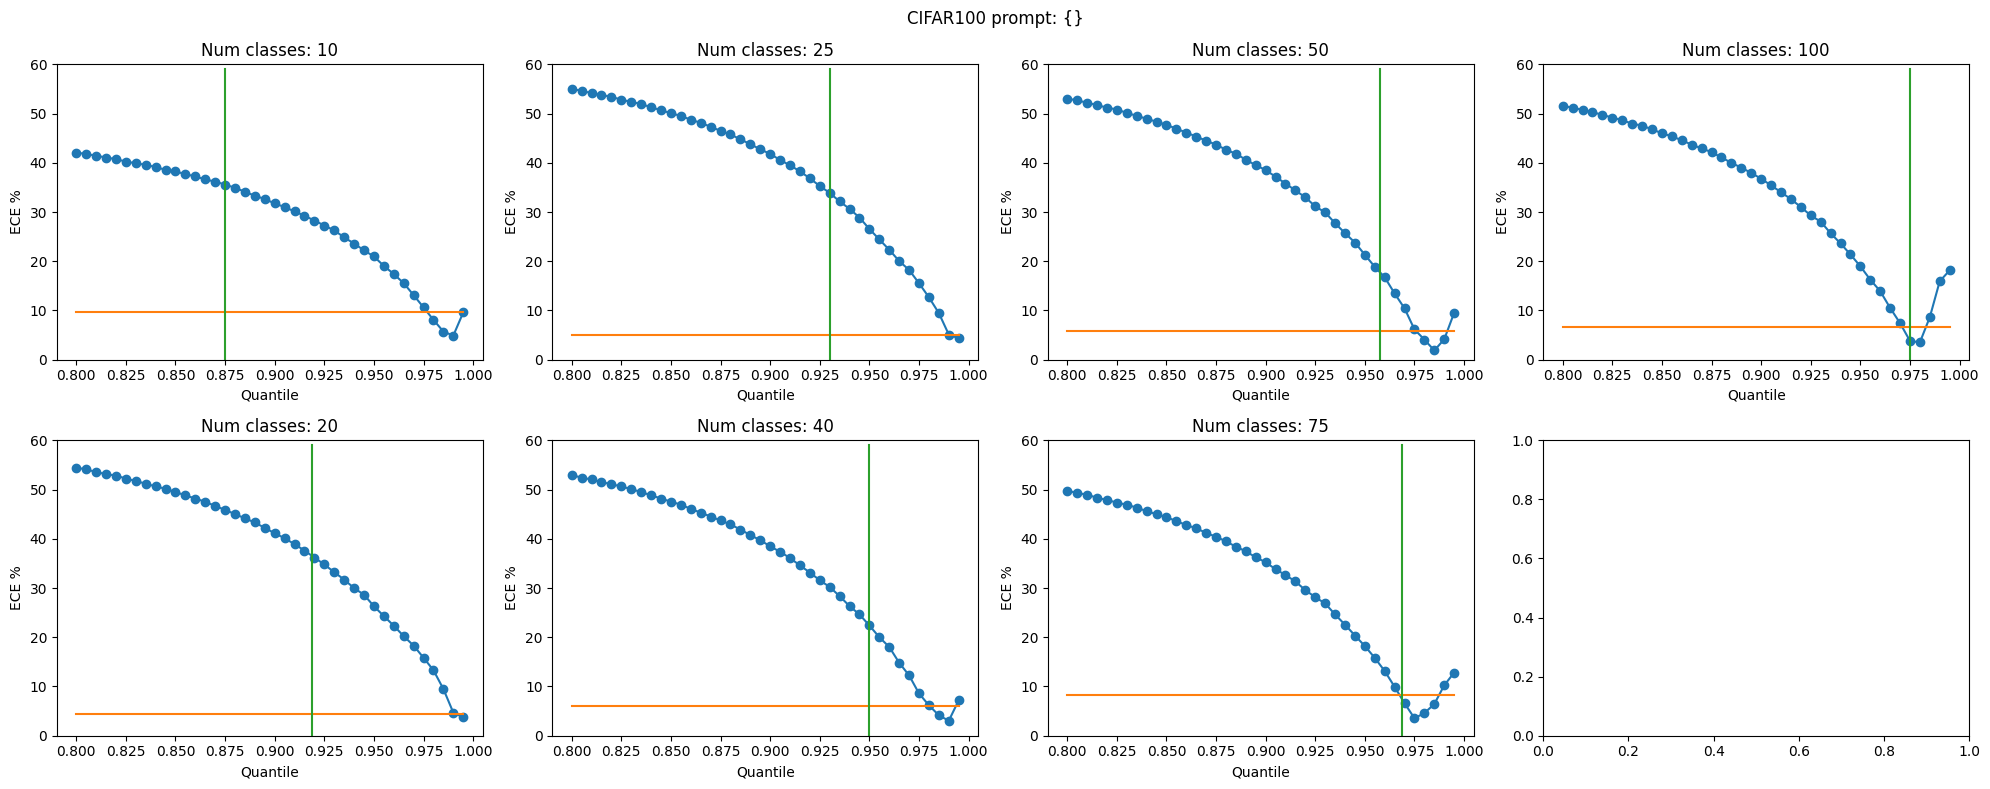

In [162]:
fig, axarr = plt.subplots(2,4, figsize=(20,8))
xaxis = np.arange(0.8, 0.9999, 0.005)
for i,k in enumerate(sorted(scaled_eces)):
    axarr[i % 2, i // 2 ].plot(xaxis, np.array(scaled_eces[k]) * 100, marker='o')
    axarr[i % 2, i // 2].plot(xaxis, np.array([normal_ece[k]]*len(xaxis)) * 100, '-')
    axarr[i % 2, i // 2].plot( [func(k)] * 60, np.arange(0,60), '-')
    axarr[i % 2, i // 2].set_title(f"Num classes: {k}")
    axarr[i % 2, i // 2].set_xlabel('Quantile')
    axarr[i % 2, i // 2].set_ylabel('ECE %')
    axarr[i % 2, i // 2].set_ylim(0, 60)
plt.suptitle(f"CIFAR100 prompt: {t}")
plt.tight_layout()

In [155]:
xaxis[-6]

0.9700000000000002

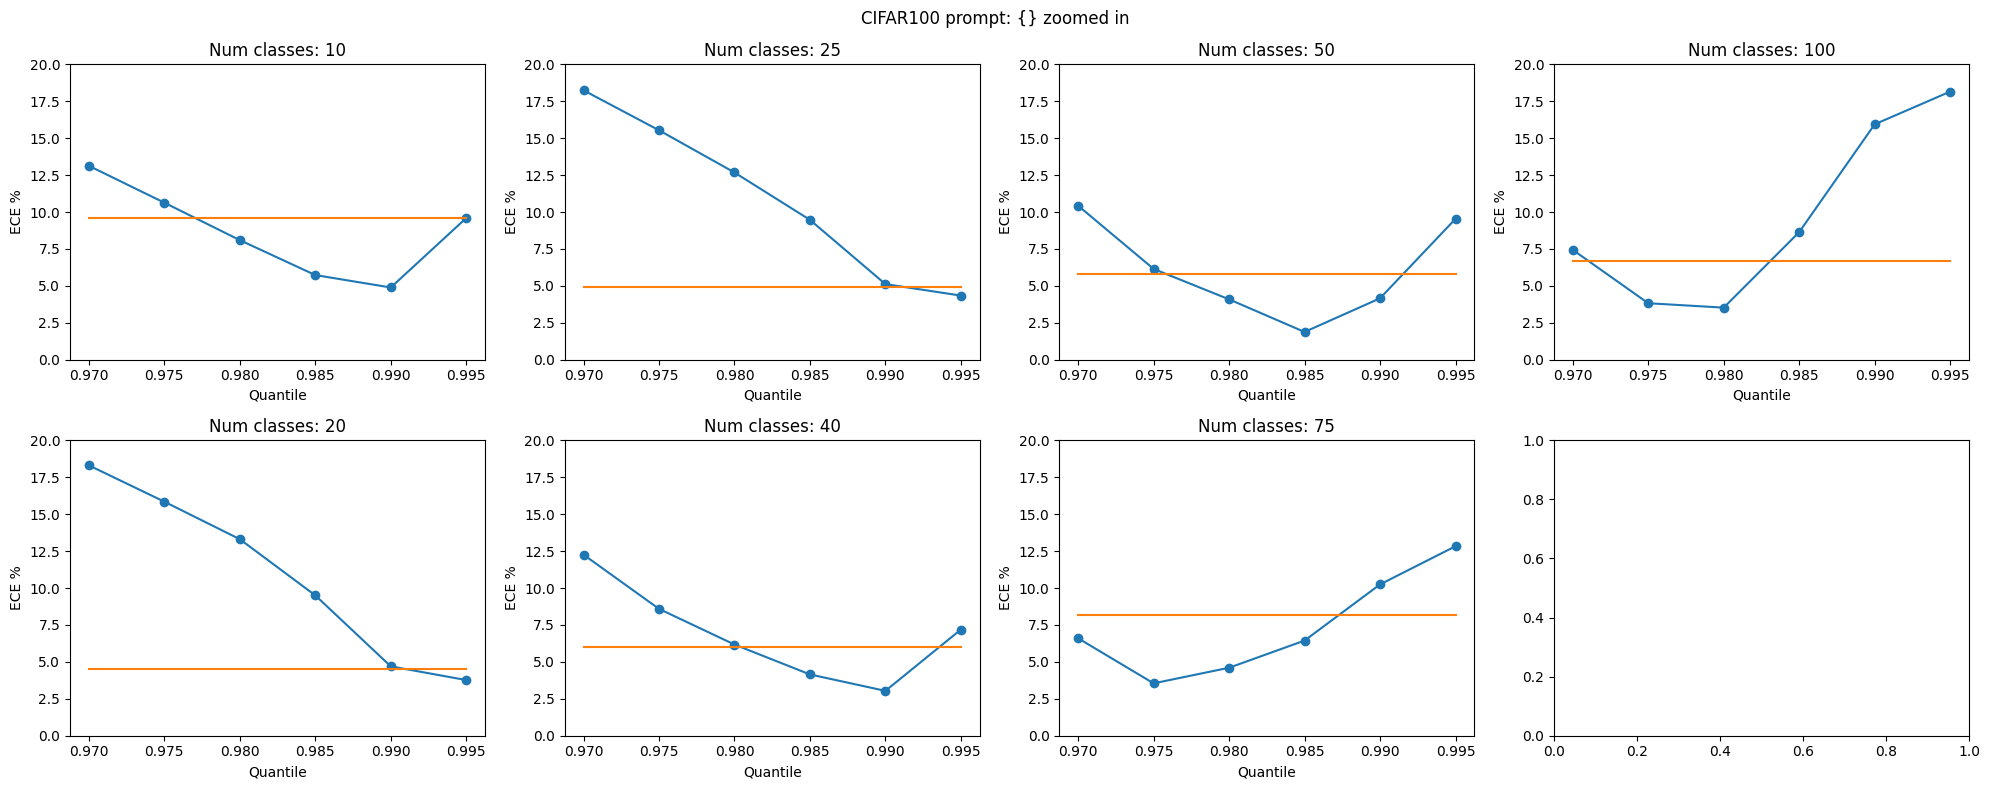

In [157]:
fig, axarr = plt.subplots(2,4, figsize=(20,8))
xaxis = np.arange(0.8, 0.9999, 0.005)
for i,k in enumerate(sorted(scaled_eces)):
    axarr[i % 2, i // 2 ].plot(xaxis[-6:], np.array(scaled_eces[k])[-6:] * 100, marker='o')
    axarr[i % 2, i // 2].plot(xaxis[-6:], np.array([normal_ece[k]]*len(xaxis))[-6:] * 100, '-')
    axarr[i % 2, i // 2].set_title(f"Num classes: {k}")
    axarr[i % 2, i // 2].set_xlabel('Quantile')
    axarr[i % 2, i // 2].set_ylabel('ECE %')
    axarr[i % 2, i // 2].set_ylim(0, 20)
plt.suptitle(f"CIFAR100 prompt: {t} zoomed in")
plt.tight_layout()

In [114]:
temps_learned, eces_learned

([3.8702056407928467,
  3.8032946586608887,
  3.7372899055480957,
  3.6668620109558105,
  3.6065869331359863,
  3.5408589839935303,
  3.4829039573669434,
  3.419480800628662,
  3.3524866104125977,
  3.2899317741394043,
  3.2311954498291016,
  3.1660869121551514,
  3.107811212539673,
  3.042039394378662,
  2.9819936752319336,
  2.923701286315918,
  2.859264850616455,
  2.797128200531006,
  2.736313819885254,
  2.6745026111602783,
  2.612238883972168,
  2.552280902862549,
  2.4905550479888916,
  2.4272868633270264,
  2.36633038520813,
  2.3071351051330566,
  2.257394552230835,
  2.186208486557007,
  2.112544536590576,
  2.046858072280884,
  1.994202971458435,
  1.9154454469680786,
  1.842942476272583,
  1.7663898468017578,
  1.6836676597595215,
  1.5956687927246094,
  1.5042688846588135,
  1.3871756792068481,
  1.2238091230392456,
  1.0000066757202148],
 [0.4208883394412697,
  0.41773154435865584,
  0.4144414956234395,
  0.41073566228896385,
  0.40740322485007346,
  0.4025472433138638,
 

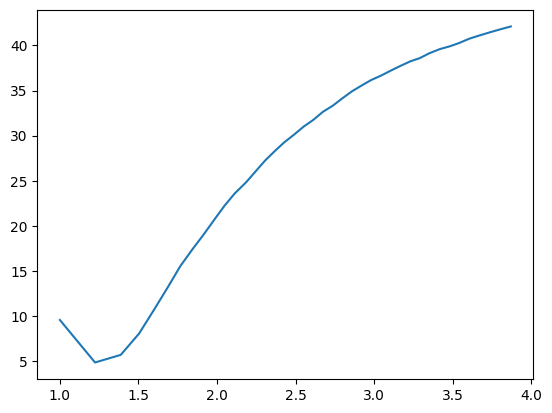

In [119]:
plt.plot(temps_learned, np.array(eces_learned) * 100.0)